# PSSM

> Functions related with PSSMs

## Setup

In [1]:
#| default_exp pssm

In [2]:
#| export
import numpy as np, pandas as pd
from katlas.data import *
from katlas.utils import *
from fastcore.meta import delegates
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
from functools import partial
from fastcore.meta import delegates

# for plot
from matplotlib import pyplot as plt
import logomaker,math
import seaborn as sns


In [3]:
#| hide
from nbdev import show_doc

In [4]:
#| hide
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', 100) # show all columns

```python
from katlas.pssm import *
```

## PSSM

In [5]:
#| export
def get_prob(df: pd.DataFrame, col: str, aa_order=[i for i in 'PGACSTVILMFYWHKRQNDEsty']):
    "Get the probability matrix of PSSM from phosphorylation site sequences."
    
    site = check_seq_df(df, col)
    
    site_array = np.array(site.apply(list).tolist())
    seq_len = site_array.shape[1]
    
    position = list(range(-(seq_len // 2), (seq_len // 2)+1)) # add 1 because range do not include the final num
    
    site_df = pd.DataFrame(site_array, columns=position)
    melted = site_df.melt(var_name='Position', value_name='aa')
    
    grouped = melted.groupby(['Position', 'aa']).size().reset_index(name='Count')
    grouped = grouped[grouped.aa.isin(aa_order)].reset_index(drop=True)
    
    pivot_df = grouped.pivot(index='aa', columns='Position', values='Count').fillna(0)
    pssm_df = pivot_df / pivot_df.sum()
    
    pssm_df = pssm_df.reindex(index=aa_order, columns=position, fill_value=0)
    pssm_df = pssm_df.rename(index={'s': 'pS', 't': 'pT', 'y': 'pY'})
    
    return pssm_df

In [6]:
ks = Data.get_ks_dataset()

In [7]:
ks_k = ks[ks.kinase_uniprot=='P00519']

In [8]:
pssm_df = get_prob(ks_k,'site_seq')
pssm_df.head()

Position,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
aa,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
P,0.050061,0.048691,0.062349,0.055489,0.046988,0.054753,0.064787,0.055090,0.056683,0.048272,0.052257,0.054599,0.053974,0.043170,0.060839,0.067138,0.049971,0.055817,0.076968,0.049354,0.0,0.020024,0.049645,0.125370,0.054997,0.056872,0.057382,0.057588,0.062048,0.053463,0.058104,0.052728,0.051140,0.069436,0.063164,0.057716,0.056639,0.051072,0.050697,0.052163,0.060703
G,0.080586,0.080341,0.069007,0.067551,0.082530,0.070397,0.093581,0.073054,0.077566,0.072706,0.067102,0.077745,0.052788,0.078060,0.070880,0.065371,0.087008,0.073443,0.084019,0.065217,0.0,0.091284,0.069740,0.062685,0.070373,0.075237,0.060371,0.072585,0.080120,0.077157,0.072783,0.099939,0.070856,0.071916,0.075672,0.071518,0.064821,0.080076,0.088720,0.062341,0.090735
A,0.080586,0.080341,0.062954,0.054282,0.075301,0.071600,0.070186,0.070060,0.065632,0.070322,0.077791,0.073591,0.053381,0.065050,0.069108,0.071849,0.062316,0.081669,0.063455,0.060517,0.0,0.102473,0.084515,0.075103,0.063276,0.075237,0.083084,0.049190,0.053614,0.073512,0.073394,0.064378,0.077634,0.069436,0.072545,0.063363,0.079924,0.088272,0.087452,0.057888,0.070927
C,0.017094,0.012781,0.013317,0.019903,0.012048,0.017449,0.007798,0.014371,0.013126,0.012515,0.023159,0.015430,0.012456,0.014784,0.010632,0.012956,0.014697,0.009988,0.010576,0.008226,0.0,0.017079,0.017730,0.023655,0.018924,0.010664,0.016736,0.010798,0.008434,0.010328,0.012232,0.007357,0.017868,0.014879,0.012508,0.011920,0.018880,0.019546,0.014575,0.019084,0.014058
S,0.047619,0.035910,0.046610,0.030157,0.037349,0.042720,0.041992,0.041916,0.034010,0.039333,0.037411,0.031454,0.043891,0.035482,0.024808,0.029446,0.026455,0.016451,0.021739,0.009401,0.0,0.019435,0.017730,0.019515,0.031934,0.029028,0.028691,0.034793,0.024699,0.032199,0.029969,0.024525,0.036352,0.047117,0.040025,0.042033,0.040277,0.039092,0.051965,0.041349,0.039617


## Transform PSSM

In [9]:
#| export
def pSTY2sty(string): return string.replace('pS', 's').replace('pT', 't').replace('pY', 'y')

In [10]:
pspa_scale = Data.get_pspa_all_scale()
pspa_scale.head()

,-5P,-5G,-5A,-5C,-5S,-5T,-5V,-5I,-5L,-5M,-5F,-5Y,-5W,-5H,-5K,-5R,-5Q,-5N,-5D,-5E,-5pS,-5pT,-5pY,-4P,-4G,-4A,-4C,-4S,-4T,-4V,-4I,-4L,-4M,-4F,-4Y,-4W,-4H,-4K,-4R,-4Q,-4N,-4D,-4E,-4pS,-4pT,-4pY,-3P,-3G,-3A,-3C,...,2E,2pS,2pT,2pY,3P,3G,3A,3C,3S,3T,3V,3I,3L,3M,3F,3Y,3W,3H,3K,3R,3Q,3N,3D,3E,3pS,3pT,3pY,4P,4G,4A,4C,4S,4T,4V,4I,4L,4M,4F,4Y,4W,4H,4K,4R,4Q,4N,4D,4E,4pS,4pT,4pY
kinase,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAK1,0.05845,0.01989,0.02305,0.03702,0.03450,0.03450,0.07720,0.12615,0.08061,0.07014,0.03450,0.07728,0.02557,0.02687,0.02127,0.07760,0.04546,0.02232,0.01299,0.01242,0.01632,0.01632,0.04960,0.04172,0.05015,0.05515,0.04375,0.04836,0.04836,0.04836,0.04851,0.05796,0.05414,0.04062,0.04172,0.03148,0.04015,0.06320,0.05586,0.04898,0.03351,0.02594,0.04375,0.02594,0.02594,0.02648,0.08610,0.04067,0.08888,0.05203,...,0.04025,0.03142,0.03142,0.03149,0.05264,0.07135,0.04499,0.05735,0.04499,0.04499,0.04715,0.02999,0.03780,0.03378,0.03324,0.04120,0.03718,0.05210,0.05712,0.06965,0.04816,0.05681,0.03131,0.02868,0.02589,0.02589,0.02775,0.05026,0.05618,0.05170,0.04826,0.04482,0.04482,0.03377,0.03321,0.03689,0.03713,0.04186,0.04170,0.06611,0.04482,0.06651,0.07427,0.05082,0.04738,0.03113,0.03657,0.02009,0.02009,0.02161
ACVR2A,0.02971,0.03443,0.04180,0.03500,0.04137,0.04137,0.04281,0.04474,0.04266,0.03729,0.04295,0.04137,0.05748,0.04080,0.03651,0.03400,0.03078,0.03837,0.06356,0.05648,0.05605,0.05605,0.05440,0.03341,0.03936,0.03979,0.03950,0.03936,0.03936,0.03893,0.03771,0.03728,0.04130,0.04438,0.04201,0.05406,0.03950,0.02911,0.03276,0.03456,0.03592,0.07456,0.06230,0.05800,0.05800,0.04882,0.03345,0.04351,0.03578,0.03918,...,0.04447,0.04786,0.04786,0.03799,0.04958,0.04381,0.03914,0.03559,0.04366,0.04366,0.04196,0.04099,0.04529,0.04358,0.04765,0.04839,0.04699,0.04366,0.03419,0.02864,0.03692,0.03877,0.04603,0.06438,0.03840,0.03840,0.06031,0.05559,0.03989,0.03652,0.03791,0.04129,0.04129,0.03784,0.04129,0.03755,0.04855,0.03835,0.04246,0.05867,0.04202,0.03865,0.03601,0.04517,0.04077,0.04693,0.04693,0.05155,0.05155,0.04319
ACVR2B,0.03779,0.03665,0.04013,0.05473,0.03779,0.03779,0.03850,0.03134,0.03339,0.03658,0.04282,0.04303,0.05112,0.03672,0.03063,0.03346,0.03531,0.04218,0.07551,0.06381,0.05402,0.05402,0.05268,0.03774,0.04406,0.04048,0.04645,0.04013,0.04013,0.03647,0.03226,0.03640,0.03521,0.04392,0.04273,0.04954,0.04287,0.02663,0.02586,0.03465,0.04013,0.07224,0.06149,0.05538,0.05538,0.05987,0.03044,0.03658,0.03579,0.03882,...,0.04579,0.06240,0.06240,0.04636,0.05072,0.04699,0.04188,0.03976,0.04268,0.04268,0.04210,0.04297,0.05006,0.04443,0.04122,0.05123,0.04845,0.03727,0.02653,0.03311,0.03888,0.03815,0.04268,0.05423,0.04633,0.04633,0.05130,0.05205,0.04200,0.04735,0.03984,0.04056,0.04056,0.03998,0.03926,0.03832,0.03774,0.03485,0.04244,0.05675,0.04056,0.03261,0.03514,0.04229,0.03846,0.05278,0.05039,0.05502,0.05502,0.04605
AKT1,0.04669,0.04599,0.04274,0.04684,0.03995,0.03995,0.03306,0.03368,0.03592,0.03910,0.04235,0.03995,0.04065,0.05056,0.07355,0.11753,0.03801,0.03616,0.02911,0.02911,0.03298,0.03298,0.03314,0.04161,0.04729,0.04091,0.03858,0.04091,0.04091,0.03461,0.03018,0.03430,0.04114,0.03360,0.03593,0.04449,0.04667,0.08455,0.12592,0.04161,0.03679,0.02598,0.03220,0.03508,0.03508,0.03166,0.02642,0.02358,0.02837,0.02748,...,0.01816,0.02271,0.02271,0.02975,0.03828,0.05555,0.03828,0.05109,0.04422,0.04422,0.03594,0.03852,0.03797,0.03852,0.04750,0.04500,0.04422,0.06000,0.07180,0.08906,0.04430,0.04875,0.02289,0.02469,0.02633,0.02633,0.02656,0.07361,0.04755,0.03900,0.03884,0.03900,0.03900,0.03301,0.03037,0.03692,0.03637,0.03109,0.02789,0.04156,0.05299,0.09151,0.08648,0.05874,0.05187,0.03541,0.02494,0.03141,0.03141,0.02102
AKT2,0.04617,0.04732,0.04931,0.04464,0.04095,0.04095,0.03321,0.03206,0.03781,0.03934,0.04203,0.04180,0.04095,0.04671,0.07516,0.11320,0.03796,0.03643,0.02339,0.02416,0.03497,0.03497,0.03651,0.04437,0.05416,0.05245,0.04390,0.04056,0.04056,0.03201,0.03023,0.03644,0.04056,0.03194,0.036

In [11]:
pspa_scale.columns.map(pSTY2sty)

Index(['-5P', '-5G', '-5A', '-5C', '-5S', '-5T', '-5V', '-5I', '-5L', '-5M',
       ...
       '4H', '4K', '4R', '4Q', '4N', '4D', '4E', '4s', '4t', '4y'],
      dtype='object', length=230)

In [12]:
#| export
def flatten_pssm(pssm_df,
                 use_sty=False, # if True, use s,t,y instead of pS,pT,pY
                ):
    "Flatten PSSM dataframe to dictionary"
    # convert pS,pT,pY to s,t,y
    pssm_df=pssm_df.copy()
    if use_sty: pssm_df.index=pssm_df.index.map(pSTY2sty)
    pssm = pssm_df.unstack().reset_index(name='value')
    # Combine position column and residue identity column as new column for keys
    pssm['position_residue']=pssm.iloc[:,0].astype(str)+pssm.iloc[:,1]
    return pssm.set_index('position_residue')['value'].round(5).to_dict()

In [13]:
series = pd.Series(flatten_pssm(pssm_df))
series

-20P    0.05006
-20G    0.08059
         ...   
20pT    0.01534
20pY    0.01597
Length: 943, dtype: float64

In [14]:
#| export
def recover_pssm(flat_pssm:pd.Series,aa_order=list('PGACSTVILMFYWHKRQNDEsty')):
    "Recover 2D PSSM from flattened PSSM Series."
    df = flat_pssm.copy().reset_index()
    df.columns=['info','value']
    df['Position']=df['info'].str.extract(r'(-?\d+)').astype(int)
    df['aa']=df['info'].str.extract(r'-?\d+\s*(.*)')
    df = df.pivot(index='aa',columns='Position',values='value').fillna(0)
    # for cases where pS, pT, pY is already used
    if 'pS' in df.index: return df
    # for cases where s, t, y needs to converted to pS, pT, pY
    else: return df.reindex(index=aa_order).rename(index={'s': 'pS', 't': 'pT', 'y': 'pY'})

In [15]:
recover_pssm(series)

Position,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
aa,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A,0.08059,0.08034,0.06295,0.05428,0.07530,0.07160,0.07019,0.07006,0.06563,0.07032,0.07779,0.07359,0.05338,0.06505,0.06911,0.07185,0.06232,0.08167,0.06345,0.06052,0.00000,0.10247,0.08452,0.07510,0.06328,0.07524,0.08308,0.04919,0.05361,0.07351,0.07339,0.06438,0.07763,0.06944,0.07255,0.06336,0.07992,0.08827,0.08745,0.05789,0.07093
C,0.01709,0.01278,0.01332,0.01990,0.01205,0.01745,0.00780,0.01437,0.01313,0.01251,0.02316,0.01543,0.01246,0.01478,0.01063,0.01296,0.01470,0.00999,0.01058,0.00823,0.00000,0.01708,0.01773,0.02365,0.01892,0.01066,0.01674,0.01080,0.00843,0.01033,0.01223,0.00736,0.01787,0.01488,0.01251,0.01192,0.01888,0.01955,0.01458,0.01908,0.01406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pT,0.01832,0.01278,0.01574,0.01508,0.01446,0.01504,0.01140,0.00719,0.00955,0.02145,0.00950,0.02077,0.02135,0.01892,0.02363,0.02120,0.02528,0.02585,0.02703,0.03467,0.04818,0.02415,0.03605,0.02720,0.03666,0.02844,0.01973,0.01860,0.01747,0.02187,0.01835,0.01962,0.01109,0.02170,0.01501,0.01443,0.01951,0.01450,0.01458,0.01209,0.01534
pY,0.01648,0.01156,0.00726,0.00905,0.01386,0.01384,0.01320,0.01078,0.01313,0.01967,0.01425,0.01306,0.01483,0.01715,0.01477,0.03121,0.02352,0.04407,0.04465,0.03760,0.89013,0.03828,0.04433,0.04080,0.02543,0.02488,0.01554,0.01800,0.01506,0.01276,0.01284,0.01962,0.01972,0.01116,0.01188,0.01004,0.00944,0.01261,0.00824,0.01908,0.01597


Or recover from PSPA data, where s, t, y will be converted to pS, pT, and pY:

In [16]:
pspa = Data.get_pspa_all_norm()

In [17]:
flat_pssm = pspa.loc['AAK1'].dropna()

In [18]:
recovered = recover_pssm(flat_pssm)
recovered

Position,-5,-4,-3,-2,-1,0,1,2,3,4
aa,,,,,,,,,,
P,0.0720,0.0534,0.1084,0.0226,0.1136,0.0,0.0463,0.0527,0.0681,0.0628
G,0.0245,0.0642,0.0512,0.0283,0.0706,0.0,0.7216,0.0749,0.0923,0.0702
...,...,...,...,...,...,...,...,...,...,...
pT,0.0201,0.0332,0.0303,0.0209,0.0121,1.0,0.0123,0.0409,0.0335,0.0251
pY,0.0611,0.0339,0.0274,0.0486,0.0178,0.0,0.0100,0.0410,0.0359,0.0270


PSPA is not scaled per position, and the recovered pssm_df also contained copies of pS,pT,pY in zero position (S,T,Y).

So we need to remove the redundant copy in zero position (leave pS/pT/pY only) and scaled to 1 per position.

In [19]:
#| export
def clean_zero_normalize(pssm_df):
    "Zero out non-last three values in position 0 (keep only s,t,y values at center), and normalize per position"
    pssm_df=pssm_df.copy()
    pssm_df.columns= pssm_df.columns.astype(int)
    pssm_df.loc[pssm_df.index[:-3], 0] = 0
    pssm_df = pssm_df/pssm_df.sum()
    return pssm_df

In [20]:
norm_pssm = clean_zero_normalize(recovered)
norm_pssm.head()

Position,-5,-4,-3,-2,-1,0,1,2,3,4
aa,,,,,,,,,,
P,0.058446,0.041715,0.086100,0.017935,0.096068,0.0,0.042649,0.040482,0.052640,0.050260
G,0.019888,0.050152,0.040667,0.022459,0.059704,0.0,0.664702,0.057536,0.071346,0.056182
A,0.023054,0.055152,0.088880,0.042695,0.032558,0.0,0.028740,0.057613,0.044987,0.051701
C,0.037016,0.043747,0.052025,0.046663,0.026469,0.0,0.020542,0.052543,0.057355,0.048259
S,0.034500,0.048356,0.041859,0.044044,0.046089,0.0,0.013172,0.042403,0.044987,0.044818


## PSSMs of clusters

In [21]:
#| export
def get_cluster_pssms(df, 
                    cluster_col, 
                    seq_col='site_seq', 
                    id_col = 'sub_site',
                    count_thr=10, valid_thr=None,plot=False):
    "Extract motifs from clusters in a dataframe"
    pssms = []
    ids = []
    # drop duplicates based both on cluster column and substrate seq id column
    value_counts = df.drop_duplicates(subset=[cluster_col,id_col])[cluster_col].value_counts()
    for cluster_id, counts in tqdm(value_counts.items(),total=len(value_counts)):
        if count_thr is not None and counts <= count_thr:
            continue

        if id_col is not None:
            df_cluster = df[df[cluster_col] == cluster_id].drop_duplicates(id_col)
        else:
            df_cluster = df[df[cluster_col] == cluster_id]
        
        n= len(df_cluster)
        pssm = get_prob(df_cluster, seq_col)
        valid_score = (pssm != 0).sum().sum() / (pssm.shape[0] * pssm.shape[1])

        if valid_thr is not None and valid_score <= valid_thr:
            continue

        pssms.append(flatten_pssm(pssm))
        ids.append(cluster_id)

        if plot:
            plot_logo(pssm, title=f'Cluster {cluster_id} (n={n})', figsize=(14, 1))
            plt.show()
            plt.close()

    pssm_df = pd.DataFrame(pssms, index=ids)
    return pssm_df

## Entropy & Information Content

In [22]:
#| export
def entropy(pssm_df,# a dataframe of pssm with index as aa and column as position
            return_min=False, # return min entropy as a single value or return all entropy as a series
            exclude_zero=False, # exclude the column of 0 (center position) in the entropy calculation
            clean_zero=True, # if true, zero out non-last three values in position 0 (keep only s,t,y values at center)
            ): 
    "Calculate entropy per position of a PSSM surrounding 0. The less entropy the more information it contains."
    pssm_df = pssm_df.copy()
    pssm_df.columns= pssm_df.columns.astype(int)
    if 0 in pssm_df.columns:
        if clean_zero:                       
            pssm_df.loc[pssm_df.index[:-3], 0] = 0
        if exclude_zero:
            pssm_df = pssm_df.drop(columns=[0])
    pssm_df = pssm_df/pssm_df.sum()
    per_position = -np.sum(pssm_df * np.log2(pssm_df + 1e-9), axis=0)
    return per_position.min() if return_min else per_position

In [23]:
# get entropy per position
entropy(pssm_df).sort_values()

Position
 0     0.608195
-1     4.148746
         ...   
-20    4.324109
-11    4.324761
Length: 41, dtype: float64

In [24]:
# calculate minimum entropy per pssm
entropy(pssm_df,True,True,True)

4.148746038698782

In [25]:
#| export
@delegates(entropy)
def entropy_flat(flat_pssm:pd.Series,**kwargs): 
    "Calculate entropy per position of a flat PSSM surrounding 0"
    pssm_df = recover_pssm(flat_pssm)
    return entropy(pssm_df,**kwargs)

In [26]:
entropy_flat(series).sort_values() # slight differences due to rounding

Position
 0     0.608192
-1     4.148763
         ...   
-20    4.324115
-11    4.324737
Length: 41, dtype: float64

In [27]:
#| export
def get_scaled_IC_standard(pssm_df):
    """Calculate the standard information content (bits) from frequency matrix, 
    using the same number of residues log2(len(pssm_df)) for all positions"""
    
    entropy_position=entropy(pssm_df)
    
    # information_content = max_entropy - entropy --> log2(N) - entropy
    IC_position = np.log2((len(pssm_df))) - entropy_position
    scaled_df = pssm_df.mul(IC_position)
    return scaled_df

In [28]:
get_scaled_IC_standard(pssm_df)

Position,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
aa,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
P,0.009985,0.012965,0.014891,0.014198,0.011902,0.012694,0.015974,0.013986,0.017089,0.009596,0.012575,0.014295,0.012250,0.011231,0.017495,0.018691,0.014269,0.020898,0.026184,0.018499,0.000000,0.007416,0.011363,0.040525,0.011582,0.015780,0.015198,0.012693,0.019187,0.013863,0.015197,0.013824,0.012853,0.014583,0.015643,0.012925,0.011664,0.012481,0.012162,0.011987,0.014786
G,0.016073,0.021392,0.016481,0.017284,0.020904,0.016321,0.023074,0.018547,0.023384,0.014454,0.016147,0.020355,0.011981,0.020308,0.020382,0.018199,0.024845,0.027498,0.028582,0.024445,0.000000,0.033810,0.015962,0.020262,0.014820,0.020876,0.015989,0.015999,0.024776,0.020007,0.019037,0.026202,0.017809,0.015103,0.018741,0.016016,0.013349,0.019569,0.021284,0.014326,0.022101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pT,0.003653,0.003403,0.003759,0.003858,0.003662,0.003487,0.002810,0.001824,0.002878,0.004265,0.002286,0.005438,0.004846,0.004923,0.006794,0.005903,0.007218,0.009679,0.009194,0.012993,0.188637,0.008943,0.008252,0.008793,0.007721,0.007890,0.005224,0.004099,0.005402,0.005671,0.004799,0.005144,0.002787,0.004557,0.003717,0.003231,0.004018,0.003544,0.003497,0.002778,0.003735
pY,0.003288,0.003079,0.001735,0.002315,0.003509,0.003208,0.003254,0.002736,0.003957,0.003910,0.003430,0.003418,0.003365,0.004462,0.004246,0.008690,0.006715,0.016499,0.015191,0.014094,3.485183,0.014178,0.010146,0.013190,0.005355,0.006904,0.004116,0.003967,0.004657,0.003308,0.003359,0.005144,0.004955,0.002344,0.002943,0.002248,0.001944,0.003082,0.001976,0.004386,0.003891


In [29]:
#| export
@delegates(entropy)
def get_IC_per_position(pssm_df,**kwargs):
    """
    Calculate the information content (bits) from a frequency matrix,
    using log2(3) for the middle position and log2(len(pssm_df)) for others.
    The higher the more information it contains.
    """
    
    entropy_position = entropy(pssm_df,**kwargs)
    
    max_entropy_array = pd.Series(np.log2(len(pssm_df)), index=pssm_df.columns)
    
    max_entropy_array[0] = np.log2(3)

    # information_content = max_entropy - entropy --> log2(N) - entropy
    IC_position = max_entropy_array - entropy_position
    return IC_position

In [30]:
get_IC_per_position(pssm_df).sort_values()

Position
-11    0.198801
-20    0.199453
         ...   
-1     0.374816
 0     0.976768
Length: 41, dtype: float64

In [31]:
#| export
@delegates(get_IC_per_position)
def get_IC_per_position_flat(flat_pssm:pd.Series,**kwargs):
    """Calculate the information content (bits) from a flattened pssm pd.Series,
    using log2(3) for the middle position and log2(len(pssm_df)) for others."""
    
    pssm_df = recover_pssm(flat_pssm)
    return get_IC_per_position(pssm_df,**kwargs)

In [32]:
get_IC_per_position_flat(series)

Position
-20    0.199447
-19    0.266280
         ...   
 19    0.229810
 20    0.243570
Length: 41, dtype: float64

In [33]:
#| export
def get_scaled_IC(pssm_df):
    """
    For plotting purpose, calculate the scaled information content (bits) from a frequency matrix,
    using log2(3) for the middle position and log2(len(pssm_df)) for others.
    """
    IC_position = get_IC_per_position(pssm_df)
    
    return pssm_df.mul(IC_position, axis=1)

In [34]:
get_scaled_IC(pssm_df)

Position,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
aa,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
P,0.009985,0.012965,0.014891,0.014198,0.011902,0.012694,0.015974,0.013986,0.017089,0.009596,0.012575,0.014295,0.012250,0.011231,0.017495,0.018691,0.014269,0.020898,0.026184,0.018499,0.000000,0.007416,0.011363,0.040525,0.011582,0.015780,0.015198,0.012693,0.019187,0.013863,0.015197,0.013824,0.012853,0.014583,0.015643,0.012925,0.011664,0.012481,0.012162,0.011987,0.014786
G,0.016073,0.021392,0.016481,0.017284,0.020904,0.016321,0.023074,0.018547,0.023384,0.014454,0.016147,0.020355,0.011981,0.020308,0.020382,0.018199,0.024845,0.027498,0.028582,0.024445,0.000000,0.033810,0.015962,0.020262,0.014820,0.020876,0.015989,0.015999,0.024776,0.020007,0.019037,0.026202,0.017809,0.015103,0.018741,0.016016,0.013349,0.019569,0.021284,0.014326,0.022101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pT,0.003653,0.003403,0.003759,0.003858,0.003662,0.003487,0.002810,0.001824,0.002878,0.004265,0.002286,0.005438,0.004846,0.004923,0.006794,0.005903,0.007218,0.009679,0.009194,0.012993,0.047059,0.008943,0.008252,0.008793,0.007721,0.007890,0.005224,0.004099,0.005402,0.005671,0.004799,0.005144,0.002787,0.004557,0.003717,0.003231,0.004018,0.003544,0.003497,0.002778,0.003735
pY,0.003288,0.003079,0.001735,0.002315,0.003509,0.003208,0.003254,0.002736,0.003957,0.003910,0.003430,0.003418,0.003365,0.004462,0.004246,0.008690,0.006715,0.016499,0.015191,0.014094,0.869450,0.014178,0.010146,0.013190,0.005355,0.006904,0.004116,0.003967,0.004657,0.003308,0.003359,0.005144,0.004955,0.002344,0.002943,0.002248,0.001944,0.003082,0.001976,0.004386,0.003891


## Plot

### Heatmap

In [35]:
#| export
@delegates(sns.heatmap)
def plot_heatmap_simple(matrix, # a matrix of values
                 title: str='heatmap', # title of the heatmap
                 figsize: tuple=(6,7), # (width, height)
                 cmap: str='binary', # color map, default is dark&white
                 **kwargs, # arguments for sns.heatmap()
                 ):
    
    "Plot heatmap based on a matrix of values"
    
    plt.figure(figsize=figsize)
    sns.heatmap(matrix, square=True,cmap=cmap, annot=False,**kwargs)
    plt.title(title)
    plt.ylabel('')
    plt.xlabel('')
    plt.yticks(rotation=0)

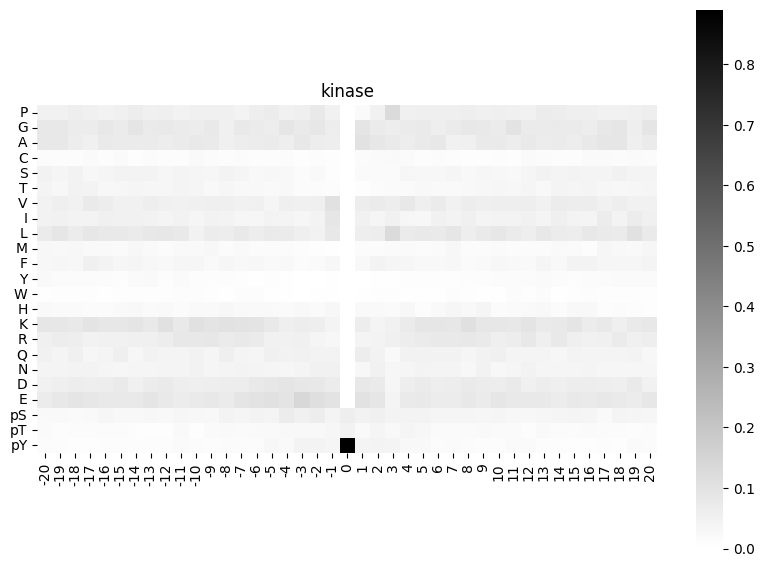

In [36]:
plot_heatmap_simple(pssm_df,'kinase',figsize=(10,7))

In [37]:
#| export
def plot_heatmap(heatmap_df, ax=None, position_label=True, figsize=(5, 6), include_zero=True):
    """Plots a heatmap with specific formatting."""
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    mask = np.zeros_like(heatmap_df, dtype=bool)
    zero_position = len(heatmap_df.columns) // 2
    
    if not include_zero:
        mask[:, zero_position] = True  # Mask position 0 if include_zero is False
    
    sns.heatmap(
        heatmap_df,
        cmap='coolwarm',
        center=0,
        linewidth=0.3,
        ax=ax,
        mask=mask  # Apply mask conditionally
    )
    
    # Access and format the color bar
    colorbar = ax.collections[0].colorbar
    colorbar.ax.set_title("Prob.", loc='center')
    
    # Add vertical lines
    ax.axvline(zero_position, color='black', linewidth=0.5)
    ax.axvline(math.ceil(len(heatmap_df.columns) / 2), color='black', linewidth=0.5)
    
    # Format the heatmap border
    ax.patch.set_edgecolor("black")
    ax.patch.set_linewidth(1.5)

    # Hide axis labels
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.xaxis.set_ticks_position('top')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    if not position_label:
        ax.set_xticklabels([])

    return ax

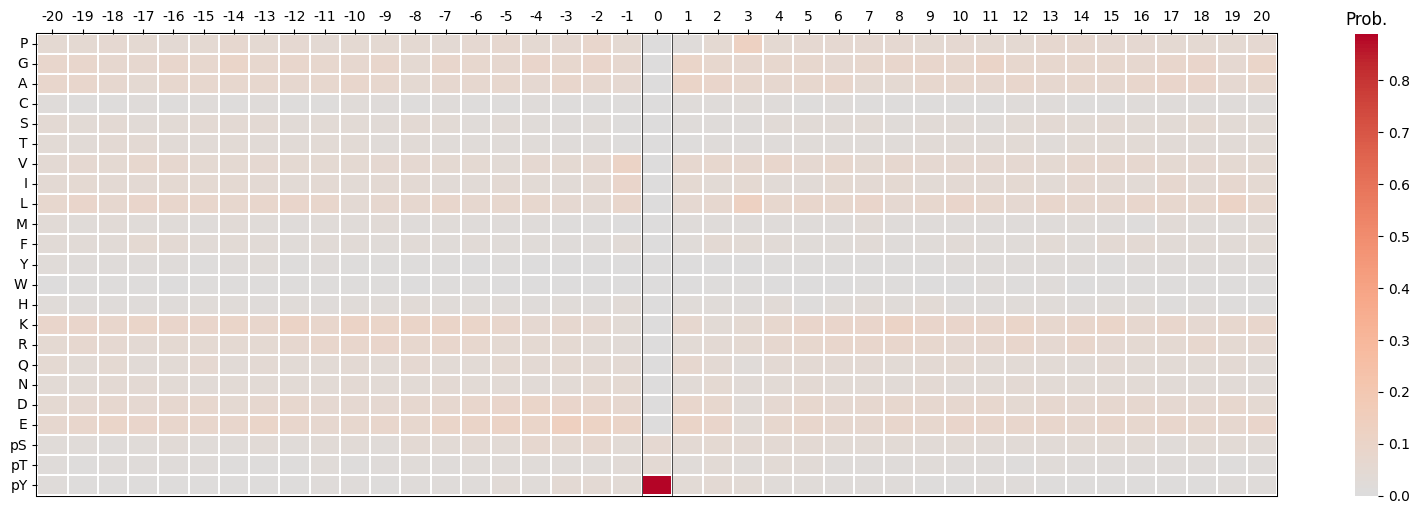

In [38]:
plot_heatmap(pssm_df,figsize=(20, 6));
# plt.savefig('plot.svg',bbox_inches='tight')

### Logo motif

In [39]:
#| export
def change_center_name(df):
    "Transfer the middle pS,pT,pY to S,T,Y for plot."
    df=df.copy()
    
    df.loc['S', 0] = df.loc['pS', 0]
    df.loc['T', 0] = df.loc['pT', 0]
    df.loc['Y', 0] = df.loc['pY', 0]
    df.loc[['pS', 'pT', 'pY'], 0] = 0
    return df

Now instead of pS, pT, and pY, the center name becomes S, T and Y:

In [40]:
change_center_name(pssm_df)[0].sort_values(ascending=False).head()

aa
Y     0.890129
S     0.061692
T     0.048179
H     0.000000
pT    0.000000
Name: 0, dtype: float64

In [41]:
#| export
def scale_zero_position(logo_df):
    "Scale position 0 to the max sum of neigboring position for better visualization."
    logo_df = logo_df.copy()
    m = logo_df.sum()[logo_df.sum().index!=0].max()
    logo_df[0] = m*(logo_df[0]/logo_df[0].sum())
    return logo_df

In [42]:
#| export
def get_logo_df(prob_df,scale_zero=True):
    logo_df = get_scaled_IC(prob_df)
    logo_df = change_center_name(logo_df)
    total_IC = logo_df.sum().sum().round(2)
    if scale_zero:
        logo_df = scale_zero_position(logo_df)
    return logo_df,total_IC

In [43]:
#| export
def plot_logo(prob_df,title='Motif', scale_zero=True,ax=None,figsize=(6,1)):
    logo_df,total_IC = get_logo_df(prob_df,scale_zero=scale_zero)
        
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    logo = logomaker.Logo(logo_df.T, color_scheme='kinase_protein', flip_below=False, ax=ax)
    logo.ax.set_ylabel("Bits")
    logo.style_xticks(fmt='%d')
    ax.set_title(f'{title}')

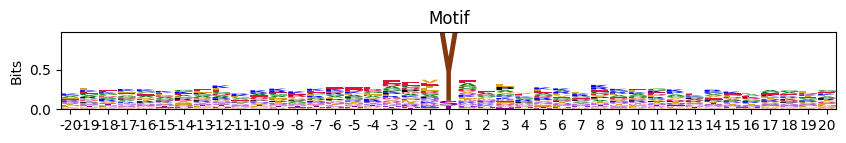

In [44]:
plot_logo(pssm_df,scale_zero=False,figsize=(10,1))

Set scale_zero to default True can have better vision of the side amino acids

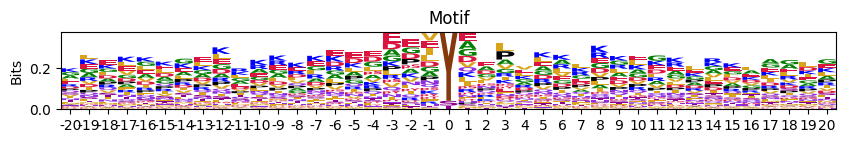

In [45]:
plot_logo(pssm_df,figsize=(10,1))

### Multiple logos

In [46]:
#| export
def plot_logos_idx(pssms_df,*idxs):
    "Plot logos of a dataframe with flattened PSSMs with index ad IDs."
    for idx in idxs:
        pssm = recover_pssm(pssms_df.loc[idx])
        plot_logo(pssm,title=f'Motif {idx}',figsize=(14,1))
        plt.show()
        plt.close()

In [47]:
#| export
def plot_logos(pssms_df, count_dict=None, path=None,prefix='Motif'):
    """
    Plot all logos from a dataframe of flattened PSSMs as subplots in a single figure.
    """
    n = len(pssms_df)
    hspace=0.7
    # 14 is width, 1 is height for each logo
    fig, axes = plt.subplots(nrows=n, figsize=(14, n * (1+hspace)),gridspec_kw={'hspace': hspace+0.1})

    if n == 1:
        axes = [axes]  # ensure axes is iterable

    for ax, idx in zip(axes, pssms_df.index):
        pssm = recover_pssm(pssms_df.loc[idx])
        if count_dict is not None:
            plot_logo(pssm, title=f'{prefix} {idx} (n={count_dict[idx]:,})',ax=ax)
        else:
            plot_logo(pssm, title=f'{prefix} {idx}',ax=ax)
    save_show(path)

### Logo motif + Heatmap

In [48]:
#| export
def plot_logo_heatmap(pssm_df, # column is position, index is aa
                       title='Motif',
                       figsize=(7,8),
                       include_zero=False
                      ):
    
    """Plot logo and heatmap vertically"""
    
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 5], width_ratios=[4, 1], hspace=0.11, wspace=0)

    ax_logo = fig.add_subplot(gs[0, 0])
    plot_logo(pssm_df,ax=ax_logo,title=title)

    ax_heatmap = fig.add_subplot(gs[1, :])
    plot_heatmap(pssm_df,ax=ax_heatmap,position_label=False,include_zero=include_zero)

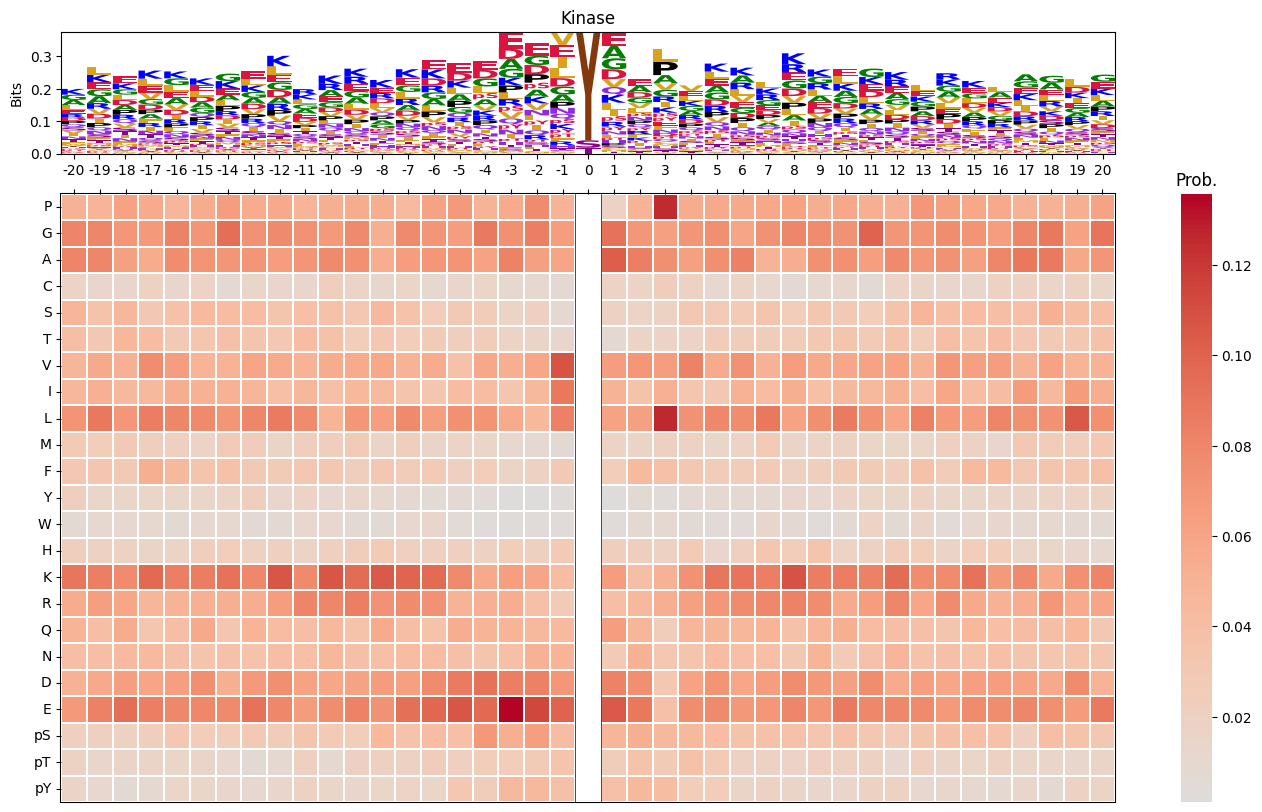

In [49]:
plot_logo_heatmap(pssm_df,'Kinase',(17,10))

## JS divergence

In [50]:
#| export
def js_divergence(p1, # pssm 
                  p2, # pssm
                  mean=True):
    "p1 and p2 are two arrays (df or np) with index as aa and column as position"
    assert p1.shape==p2.shape
    mask = (p1 + p2) > 0 #skip those with double 0
    p1,p2 = p1[mask], p2[mask]
    
    m = 0.5 * (p1 + p2)
    js = 0.5 * np.sum(p1 * np.log(p1 / m + 1e-10), axis=0) + \
         0.5 * np.sum(p2 * np.log(p2 / m + 1e-10), axis=0)
    return np.mean(js) if mean else js

In [51]:
js_divergence(pssm_df,pssm_df)

1.0000000826903708e-10

In [52]:
#| export
def js_divergence_flat(p1_flat, # pd.Series of flattened pssm
                       p2_flat, # pd.Series of flattened pssm
                       ):

    "p1 and p2 are two flattened pd.Series with index as aa and column as position"

    js = js_divergence(p1_flat,p2_flat,mean=False)
    total_position = len(p1_flat.index.str.extract(r'(-?\d+)').drop_duplicates())
    return js/total_position

In [53]:
flat_norm_pssm = pd.Series(flatten_pssm(norm_pssm))

In [54]:
js_divergence(flat_norm_pssm,flat_norm_pssm)

1.0000050826907844e-09

In [55]:
#| export
def compute_distance_matrix(df,func):
    "Compute 1D distance matrix for each row in a dataframe given a distance function "
    n = len(df)
    dist = []
    for i in tqdm(range(n)):
        for j in range(i+1, n):
            d = func(df.iloc[i], df.iloc[j])
            dist.append(d)
    return np.array(dist)

In [56]:
#| export
def compute_JS_matrix(df): 
    "Compute 1D distance matrix using JS divergence."
    return compute_distance_matrix(df,js_divergence_flat)

Parallel computing to accelerate when flattened pssms are too many in a df:

In [57]:
#| export
def compute_distance(pair, df, func):
    i, j = pair
    return func(df.iloc[i], df.iloc[j])

In [58]:
#| export
def compute_distance_matrix_parallel(df, func, max_workers=4, chunksize=100):
    n = len(df)
    index_pairs = [(i, j) for i in range(n) for j in range(i + 1, n)]

    bound_worker = partial(compute_distance, df=df, func=func)

    dist = process_map(bound_worker, index_pairs, max_workers=max_workers, chunksize=chunksize)
    return np.array(dist)

In [59]:
#| export
@delegates(compute_distance_matrix_parallel)
def compute_JS_matrix_parallel(df, func=js_divergence_flat, **kwargs): 
    "Compute 1D distance matrix using JS divergence."
    return compute_distance_matrix_parallel(df, func=func, **kwargs)

## Hierarchical clustering

In [60]:
#| export
def pssm_to_seq(pssm_df, 
                thr=0.4, # threshold of probability to show in sequence
                clean_center=True, # if true, zero out non-last three values in position 0 (keep only s,t,y values at center)
                ):
    "Represent PSSM in string sequence of amino acids"
    
    pssm_df = pssm_df.copy()
    if clean_center:
        pssm_df.loc[pssm_df.index[:-3], 0] = 0  # keep only s,t,y in center 0 position

    pssm_df.index = pssm_df.index.map(lambda x: x.replace('pS', 's').replace('pT', 't').replace('pY', 'y'))

    consensus = []
    for i, col in enumerate(pssm_df.columns):
        # consider the case where sum for the position is 0
        column_vals = pssm_df[col]
        if column_vals.sum() == 0:
            symbol = '_'
        else:
            top = column_vals.nlargest(3)
            passing = [aa for aa, prob in zip(top.index, top.values) if prob > thr]

            if not passing:
                symbol = '.'
            elif len(passing) == 1:
                symbol = passing[0]
            else:
                symbol = f"[{'/'.join(passing)}]"
                
        if col == 0:  # center position
            if symbol.startswith('['):
                symbol = symbol[:-1] + ']*'
            else:
                symbol += '*'

        consensus.append(symbol)

    return ''.join(consensus)

In [61]:
pssm_to_seq(pssm_df,thr=0.1)

'........K.K.K..E.EEVy*[E/A].[L/P]....K..........L.'

In [62]:
#| export
def plot_dendrogram(Z,output='dendrogram.pdf',color_thr=0.03,**kwargs):
    length=(len(Z)+1)//7
    
    plt.figure(figsize=(5,length))
    dendrogram(Z, orientation='left', leaf_font_size=7, color_threshold=color_thr,**kwargs)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.ylabel('Distance')
    plt.savefig(output, bbox_inches='tight')
    plt.close()

In [63]:
# pssms2 = get_cluster_pssms(all_site_long,
#                            'cluster_new',
#                            count_thr=10,
#                            blank_thr=0.3)
# distances = compute_JS_matrix_parallel(pssms2)
# Z = linkage(distances, method='ward')
# labels=[str(i)+f' (n={count_map[i]:,})' + ': '+pssm_to_seq(recover_pssm(r),0.2) for i,r in pssms2.iterrows()]
# plot_dendrogram(Z,output='out/dendrogram_label.pdf',labels=labels,color_thr=0.07)

### Represent PSSM in string

## PSPA

### Normalization

In [64]:
#| export
def raw2norm(df: pd.DataFrame, # single kinase's df has position as index, and single amino acid as columns
             PDHK: bool=False, # whether this kinase belongs to PDHK family 
            ):
    
    "Normalize single ST kinase data"
    columns_to_exclude = ['S', 'T', 'C', 't', 'y']
    
    if PDHK:
        columns_to_exclude.append('Y')
        divisor = 16
    else:
        divisor = 17
    
    s = df.drop(columns=columns_to_exclude).sum(1)
    df2 = df.div(s, axis=0)
    df2.C = df2.C / (df2.C.median() * divisor)
    df2['S'] = df2.drop(columns=columns_to_exclude).median(1)
    df2['T'] = df2.drop(columns=columns_to_exclude).median(1)
    df2 = round(df2, 4)
    
    return df2

This function implement the normalization method from [Johnson et al. Nature: An atlas of substrate specificities for the human serine/threonine kinome](https://www.nature.com/articles/s41586-022-05575-3#Sec6)

Specifically,
> - matrices were column-normalized at all positions by the sum of the 17 randomized amino acids (excluding serine, threonine and cysteine), to yield PSSMs. 
>- PDHK1 and PDHK4 were normalized to the 16 randomized amino acids (excluding serine, threonine, cysteine and additionally tyrosine)
>- The cysteine row was scaled by its median to be 1/17 (1/16 for PDHK1 and PDHK4). 
>- The serine and threonine values in each position were set to be the median of that position.
>- The S0/T0 ratio was determined by summing the values of S and T rows in the matrix (SS and ST, respectively), accounting for the different S vs. T composition of the central (1:1) and peripheral (only S or only T) positions (Sctrl and Tctrl, respectively), and then normalizing to the higher value among the two (S0 and T0, respectively, Supplementary Note 1)

This function is usually implemented with the below function, with `normalize` being a bool argument.

In [65]:
#| export
def get_one_kinase(df: pd.DataFrame, #stacked dataframe (paper's raw data)
                   kinase:str, # a specific kinase
                   normalize: bool=False, # normalize according to the paper; special for PDHK1/4
                   drop_s: bool= True, # drop s as s is a duplicates of t in PSPA
                  ):
    "Obtain a specific kinase data from stacked dataframe"
    
    p = pd.DataFrame(df.loc[kinase],columns = [kinase]).reset_index().rename(columns={'index':'substrate'})
    p['position'] = p.substrate.str.extract('(-?\d+)')
    p['aa'] = p.substrate.str[-1]
    p.position = p.position.astype(int)
    pp = p.pivot(index='position', columns='aa', values=kinase)
    if drop_s:
        if 's' in pp.columns:
            pp = pp.drop(columns=['s'])

    if normalize:
        pp = raw2norm(pp, PDHK=True if kinase == 'PDHK1' or kinase == 'PDHK4' else False)
    return pp

Retreive a single kinase data from PSPA data that has an format of kinase as index and position+amino acid as column.

In [66]:
data = Data.get_pspa_st_norm()

In [67]:
get_one_kinase(data,'PDHK1')

aa,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y,t,y
position,,,,,,,,,,,,,,,,,,,,,,
-5,0.0594,0.0625,0.0589,0.0550,0.0775,0.0697,0.0687,0.0590,0.0515,0.0657,0.0687,0.0613,0.0451,0.0424,0.0594,0.0594,0.0594,0.0573,0.1001,0.0775,0.0583,0.0658
-4,0.0618,0.0621,0.0550,0.0511,0.0739,0.0715,0.0598,0.0601,0.0520,0.0614,0.0744,0.0549,0.0637,0.0552,0.0617,0.0608,0.0608,0.0519,0.0916,0.0739,0.0528,0.0752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,0.0486,0.0609,0.0938,0.0684,0.1024,0.0676,0.0544,0.0583,0.0388,0.0552,0.0637,0.0505,0.0686,0.0502,0.0561,0.0588,0.0588,0.0593,0.0641,0.1024,0.0539,0.0431
4,0.0565,0.0749,0.0631,0.0535,0.0732,0.0655,0.0664,0.0625,0.0496,0.0552,0.0627,0.0640,0.0677,0.0553,0.0604,0.0626,0.0626,0.0579,0.0864,0.0732,0.0548,0.0575


### Plot PSPA logo motif

In [68]:
#| export
def plot_logo_raw(logo_df,ax=None,title='Motif',ytitle='Enrichment',figsize=(6,2)):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    logo = logomaker.Logo(logo_df.T, color_scheme='kinase_protein', flip_below=False, ax=ax)
    logo.ax.set_ylabel(ytitle)
    logo.style_xticks(fmt='%d')
    ax.set_title(title)

In [69]:
#| export
def get_logo(df: pd.DataFrame, # stacked Dataframe with kinase as index, substrates as columns
             kinase: str, # a specific kinase name in index
             ):
    "Given stacked df (index as kinase, columns as substrates), get a specific kinase's logo"
    
    
    # get raw kinase to calculate S/T
    pp = get_one_kinase(df,kinase,normalize=False)
    
    # get S/T ratio value
    ss = pp['S'].sum()
    st = pp['T'].sum()

    S_ctrl = 0.75*ss - 0.25*st
    T_ctrl = 0.75*st - 0.25*ss

    S0 = S_ctrl / max(S_ctrl, T_ctrl)
    T0 = T_ctrl / max(S_ctrl, T_ctrl)

    S_ratio = S0/(S0+T0)
    T_ratio = T0/(S0+T0)
    
    # get normalized kinase
    norm_p = get_one_kinase(df,kinase, normalize=True)
    
    # calculate ratio, divide values by median, followed by log2 transformation
    ratio =norm_p.apply(lambda r: r/r.median(),axis=1)
    ratio = np.log2(ratio)

    m = ratio.apply(lambda row: row[row > 0].sum(), axis=1).max()

    new_row = pd.DataFrame({'S': S_ratio*m, 'T':T_ratio*m}, index=[0]) 

    ratio2 = pd.concat([ratio, new_row], ignore_index=False).fillna(0)
    
    # plot logo
    # logo_func(ratio2, kinase)
    plot_logo_raw(ratio2.T,title=kinase)

This function is to replicate the motif logo from [Johnson et al. Nature: An atlas of substrate specificities for the human serine/threonine kinome](https://www.nature.com/articles/s41586-022-05575-3). Given raw PSPA data, it can output a motif logo.

In [70]:
# load raw PSPA data
df = pd.read_csv('https://github.com/sky1ove/katlas_raw/raw/refs/heads/main/nbs/raw/pspa_st_raw.csv').set_index('kinase')
df.head()

,-5P,-5G,-5A,-5C,-5S,-5T,-5V,-5I,-5L,-5M,-5F,-5Y,-5W,-5H,-5K,-5R,-5Q,-5N,-5D,-5E,-5s,-5t,-5y,-4P,-4G,-4A,-4C,-4S,-4T,-4V,-4I,-4L,-4M,-4F,-4Y,-4W,-4H,-4K,-4R,-4Q,-4N,-4D,-4E,-4s,-4t,-4y,-3P,-3G,-3A,-3C,...,2E,2s,2t,2y,3P,3G,3A,3C,3S,3T,3V,3I,3L,3M,3F,3Y,3W,3H,3K,3R,3Q,3N,3D,3E,3s,3t,3y,4P,4G,4A,4C,4S,4T,4V,4I,4L,4M,4F,4Y,4W,4H,4K,4R,4Q,4N,4D,4E,4s,4t,4y
kinase,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAK1,7614134.38,2590563.43,3001315.49,4696631.43,4944311.77,8315837.72,10056545.00,16433061.43,10499735.53,9133577.86,4493053.86,10062728.22,3327454.51,3504742.95,2767294.24,10105742.33,5923673.04,2909152.87,1695155.97,1617848.59,2128670.48,2128670.48,6460994.89,5260312.92,6325834.43,6957993.77,5369434.90,5713920.54,6612201.68,6093662.03,6120308.98,7306988.18,6829677.84,5119221.55,5263235.93,3974771.07,5065007.89,7968511.43,7041049.08,6174443.51,4228327.20,3271230.67,5511933.84,3267817.62,3267817.62,3338569.94,8921287.46,4210322.63,9202467.84,5247517.95,...,5087031.12,3976345.18,3976345.18,3984759.21,7873214.56,10666925.10,6726092.35,8347110.75,8474126.59,36243425.13,7049439.08,4480458.41,5646461.38,5049205.04,4966940.21,6154422.64,5554384.65,7784625.71,8536454.84,10411516.21,7199439.88,8496115.61,4678462.79,4293019.55,3871242.35,3871242.35,4144314.24,6754640.94,7548893.13,6945441.59,6316583.85,5852227.64,11986373.78,4544765.44,4468425.80,4958371.35,4992757.20,5630292.14,5605199.37,8889242.83,6020662.73,8938081.41,9983402.01,6833481.55,6364453.29,4189045.89,4921595.57,2705053.53,2705053.53,2909279.71
ACVR2A,4991039.28,5783855.86,7015770.78,8367603.09,7072052.48,7601399.57,7188292.41,7513915.73,7159894.71,6266122.81,7217726.01,6944709.95,9655463.75,6855044.90,6135259.88,5714942.29,5174360.28,6446237.55,10676798.47,9490370.51,9417512.45,9417512.45,9143262.67,5189500.90,6115977.27,6183207.45,8746774.91,8620216.35,8958568.82,6057960.27,5865979.65,5795429.17,6425254.28,6896823.79,6528270.38,8404648.40,6144455.59,4524121.26,5095303.46,5374811.94,5585576.72,11592053.32,9685649.12,9011965.48,9011965.48,7594632.10,5362570.64,6972103.63,5730145.40,8939563.00,...,6089086.81,6553062.94,6553062.94,5204999.87,6765402.33,5981896.69,5346578.80,6919984.14,7959489.88,7230276.28,5724908.70,5600557.92,6186548.03,5952584.60,6508513.22,6613614.54,6419485.14,5958101.56,4666926.40,3909037.15,5041118.65,5297856.53,6281516.23,8795439.82,5241575.71,5241575.71,8237893.33,7993593.88,5729648.65,5252569.87,7759899.88,5847330.49,6832130.05,5439639.57,5935276.66,5396841.45,6976824.69,5517910.17,6107147.03,8435953.93,6039472.76,5556300.56,5178734.62,6490097.70,5862480.97,6742905.78,6750653.36,7414220.16,7414220.16,6209576.97
ACVR2B,26480329.10,25689687.16,28137300.90,45175909.30,32876722.90,33516959.03,27011194.06,21996255.94,23412987.54,25670581.40,30029680.93,30172687.84,35861732.85,25743398.12,21466618.54,23457282.42,24765933.65,29600378.31,52942189.79,44756418.68,37869524.53,37869524.53,36929423.91,26315617.68,30726667.27,28226685.89,38126762.75,43013450.33,42772589.49,25461877.69,22496529.73,25367364.10,24579622.29,30632363.88,29811628.74,34569034.39,29901290.43,18566682.92,18058410.71,24160712.63,28003909.47,50383510.79,42873444.64,38601826.06,38601826.06,41781415.03,21589896.66,25896930.06,25366399.23,32391161.86,...,28198813.13,38385326.47,38385326.47,28511534.88,32570983.87,30150790.48,26899530.88,30059325.25,38558739.93,36859921.47,27039358.24,27590185.37,32159022.90,28530956.88,26440586.17,32902030.17,31106381.62,23931820.75,17025117.96,21234075.57,24959228.30,24492089.19,27379743.65,34799587.30,29745626.40,29745626.40,32930899.01,35872341.41,28942663.95,32630294.18,32307682.27,29351484.80,32158594.62,27585750.22,27087769.55,26427108.32,26008460.67,24006599.74,29260306.53,39105460.91,27984195.21,22496915.32,24236904.72,29132857.30,26527389.14,36388726.15,34729319.54,37906081.09,37906081.09,31761418.56
AKT1,18399509.29,18104681.05,16831835.48,17247743.90,22647275.57,17801288.32,13037570.99,132718

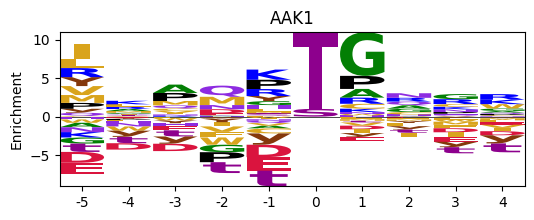

In [71]:
# plot logo of a kinase
get_logo(df, 'AAK1')

## End

In [77]:
#| hide
import nbdev; nbdev.nbdev_export()

In [73]:
#| hide
# def get_freq(df_k: pd.DataFrame, # a dataframe for a single kinase that contains phosphorylation sequence splitted by their position
#              aa_order = [i for i in 'PGACSTVILMFYWHKRQNDEsty'], # amino acid to include in the full matrix 
#              aa_order_paper = [i for i in 'PGACSTVILMFYWHKRQNDEsty'], # amino acid to include in the partial matrix
#              position = [i for i in range(-7,8)], # position to include in the full matrix
#              position_paper = [-5,-4,-3,-2,-1,1,2,3,4] # position to include in the partial matrix
#              ):
    
#     "Get frequency matrix given a dataframe of phosphorylation sites for a single kinase"
    

#     #Count frequency for each amino acid at each position
#     melted_k = df_k.melt(
#                     value_vars=[i for i in range(-7, 8)],
#                     var_name='Position', 
#                     value_name='aa')
    
#     # Group by Position and Amino Acid and count occurrences
#     grouped = melted_k.groupby(['Position', 'aa']).size().reset_index(name='Count')
    

#     # Remove wired amino acid
#     aa_include = [i for i in 'PGACSTVILMFYWHKRQNDEsty']
#     grouped = grouped[grouped.aa.isin(aa_include)].reset_index(drop=True)
    
#     # get pivot table
#     pivot_k = grouped.pivot(index='aa', columns='Position', values='Count').fillna(0)
    
#     # Get frequency by dividing the sum of each column
#     freq_k = pivot_k/pivot_k.sum()

    
#     # data from the kinase-substrate dataset, and format is Lew's paper's format
#     paper = freq_k.reindex(index=aa_order_paper,columns=position_paper,fill_value=0)

#     # full pivot data from kinase-substrate dataset
#     full = freq_k.reindex(index=aa_order,columns=position, fill_value=0)

    
#     return paper,full

# # get frequency matrix
# paper_format, full = get_freq(ks_k)
# paper_format.head()

# def get_unique_site(df:pd.DataFrame = None,# dataframe that contains phosphorylation sites
#                     seq_col: str='site_seq', # column name of site sequence
#                     id_col: str='gene_site' # column name of site id
#                    ):
#     "Remove duplicates among phosphorylation sites; return df with new columns of acceptor and number of duplicates"
    
#     unique = df.groupby(seq_col).agg(
#         {id_col: lambda r: '|'.join(r.unique())} )
#     unique['num_site'] = unique[id_col].str.split('|').apply(len) 
#     unique = unique.reset_index()
#     position = len(unique[seq_col][0])//2
#     unique['acceptor'] = unique[seq_col].str[position]
    
#     return unique

# As there are lots of duplicates of the phosphorylation site sequence in the dataset, it could be helpful to remove the duplicated sequences. 

# Implement `get_unique_site` to get unique phosphorylation sites. Need to inform columns of sequence and id.

# df = Data.get_ochoa_site()
# unique = get_unique_site(df,seq_col='site_seq',id_col='gene_site')
# unique.sort_values('num_site',ascending=False).head()